In [1]:
import torch
import torch.nn as nn
import numpy as np

import sys

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\Admin\AppData\Local\Temp\ipykernel_8180\2870380934.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


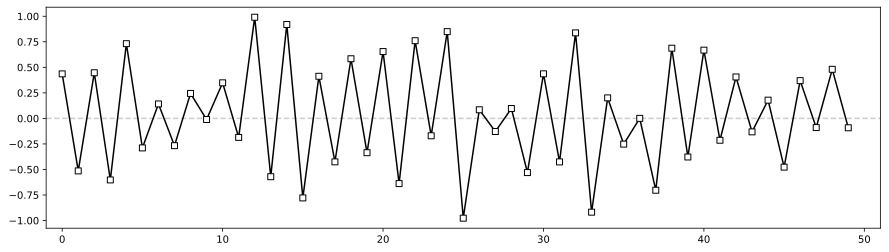

In [2]:
# import the data
N = 50

data = torch.zeros(N)

for i in range(N):
    data[i] = torch.rand(1) * (-1)**i

plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

In [3]:
class rnnnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()

        # RNN layer
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):
        
        # run thru the RNN layer
        y, hidden = self.rnn(x) # no explicit hidden state initialization

        # pass the RNN output thru the linear output layer
        y = self.out(y)
        
        return y, hidden

In [4]:
# network parameters
input_size = 1 # 'channels' of data
num_hidden = 5 # breadth of model (no. of units in hidden layers)
num_layers = 1 # depth of model (number of 'stacks' of hidden layers)
seqlength = 9 # number of datapoints used for learning in each segment
batchsize = 1 # the training code is actually hard-coded to organize data into batchsize = 1

# create an instance of the model and inspect
net = rnnnet(input_size, num_hidden, num_layers)

X = torch.rand(seqlength, batchsize, input_size)
y, h = net(X)
print(X.shape)
print(y.shape)
print(h.shape)

torch.Size([9, 1, 1])
torch.Size([9, 1, 1])
torch.Size([1, 1, 5])


In [7]:
# test the model with some data
somedata = data[:seqlength].view(seqlength, 1, 1) # convert from 1d vector to tensor
# .view(seqlength, 1, 1) reshapes it to 3D:
# Shape = (sequence_length, batch_size=1, input_size=1)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]
# y[0] is the output sequence: a tensor of predictions at each time step.
# y[0][-1] extracts the final output from the sequence — i.e., the prediction at the last time step.

lossfun = nn.MSELoss()
lossfun(finalValue, data[seqlength].view(1, 1))
# finalValue: predicted value from the model at the last step
# data[seqlength].view(1, 1): the actual next value (i.e., ground truth)

tensor(0.0007, grad_fn=<MseLossBackward0>)

In [8]:
# number of training epochs
numepochs = 30

# create a new instance of the model
net = rnnnet(input_size, num_hidden, num_layers)
optimizer = torch.optim.SGD(net.parameters(), lr = .001)

# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over data segments
    seglosses = []
    segacc = []
    hidden_state = torch.zeros(num_layers, batchsize, num_hidden) # reset the hidden state on each epoch

    for timei in range(N - seqlength):

        # grab a snippet of data
        X = data[timei:timei + seqlength].view(seqlength, 1, 1)
        y = data[timei + seqlength].view(1, 1)

        # forward pass and loss
        yHat, hidden_state = net(X)
        finalValue = yHat[-1]
        loss = lossfun(finalValue, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this segment
        seglosses.append(loss.item())

        # also get sign accuracy
        truesign = np.sign(torch.squeeze(y).numpy())
        predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
        accuracy = 100 * (truesign == predsign)
        segacc.append(accuracy)

    # avg losses from this epoch
    losses[epochi] = np.mean(seglosses)
    signaccuracy[epochi] = np.mean(segacc)

    msg = f'Finished epoch {epochi + 1}/{numepochs}'
    sys.stdout.write('\r' + msg)

Finished epoch 30/30

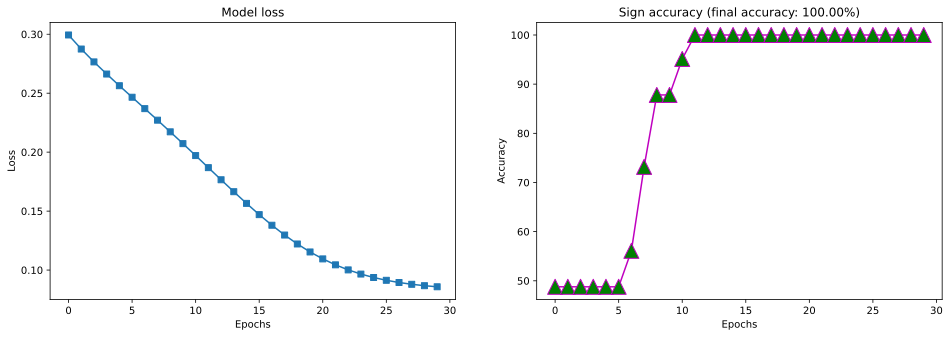

In [9]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_8180\3725167223.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h[timei + seqlength, :] = hh.detach()
C:\Users\Admin\AppData\Local\Temp\ipykernel_8180\3725167223.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[1].plot(data-yHat,'k^')


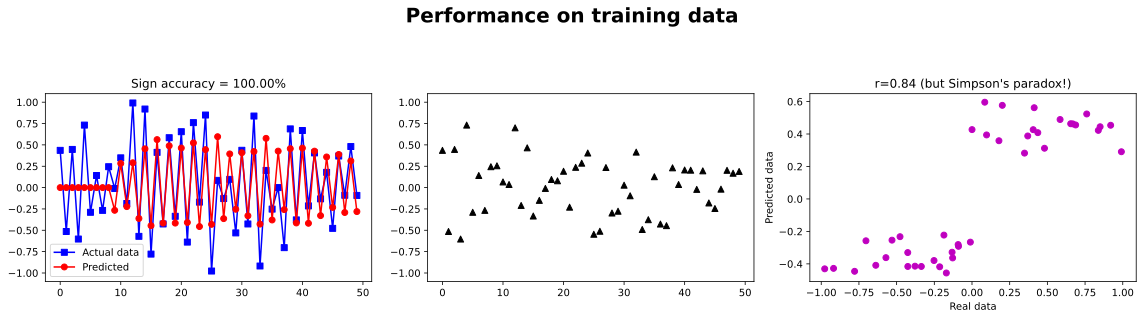

In [12]:
# now test the network

# initalize hidden state
h = np.zeros((N, num_hidden))

# initialize predicted values
yHat = np.zeros(N)

# loop over time segments
for timei in range(N - seqlength):

    # grab a snippet of data
    X = data[timei:timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss
    yy, hh = net(X)
    yHat[timei + seqlength] = yy[-1]
    h[timei + seqlength, :] = hh.detach()

# compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:] == predsign[seqlength:])

fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

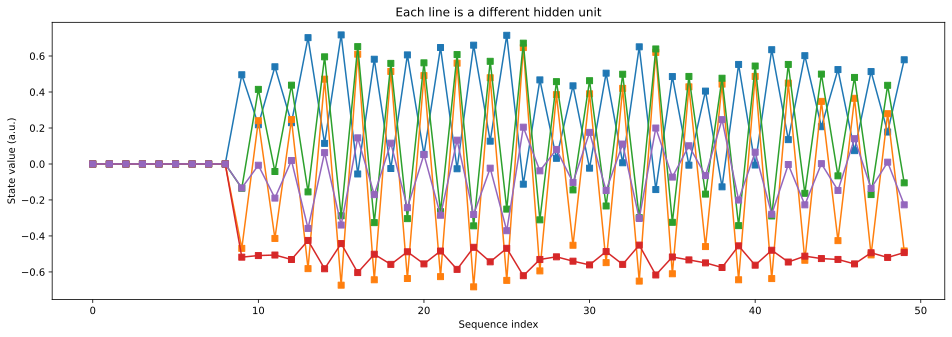

In [13]:
# show the hidden 'states' (units activation)
plt.figure(figsize = (16, 5))

plt.plot(h, 's-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

In [14]:
# test with new data

# create new data with flipped signs
newdata = torch.zeros(N)
for i in range(N):
    newdata[i] = torch.rand(1) * (-1)**(i + 1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8180\3261735203.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h[timei + seqlength, :] = hh.detach()
C:\Users\Admin\AppData\Local\Temp\ipykernel_8180\3261735203.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[1].plot(newdata-yHat,'k^')


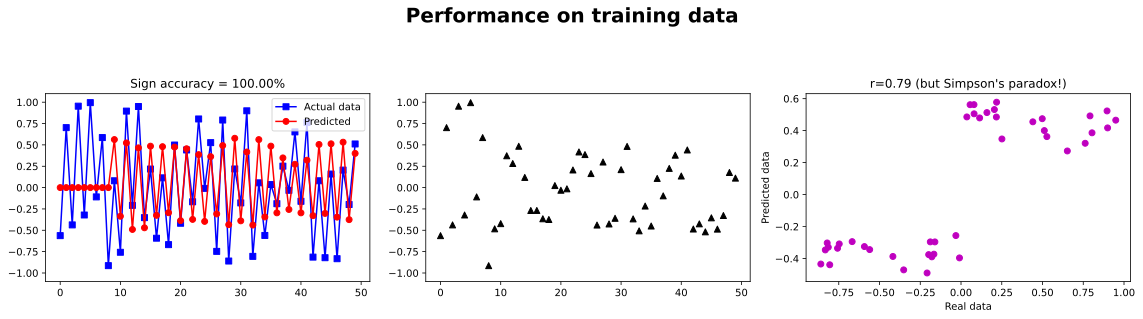

In [15]:
# now test the network
# no learning here

h = np.zeros((N, num_hidden))

yHat = np.zeros(N)
for timei in range(N - seqlength):

    # grab a snippet of data
    X = newdata[timei:timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss
    yy, hh = net(X)
    yHat[timei + seqlength] = yy[-1]
    h[timei + seqlength, :] = hh.detach()

# compute sign-accuracy
truesign = np.sign(newdata.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:] == predsign[seqlength:])

fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newdata,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(newdata-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(newdata[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(newdata[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

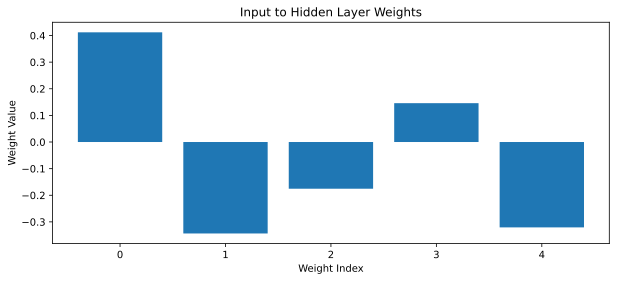

In [17]:
weights = net.rnn.weight_ih_l0.detach().numpy().flatten()

# Plot the flattened weights
plt.figure(figsize=(10, 4))
plt.bar(range(len(weights)), weights)
plt.ylabel('Weight Value')
plt.xlabel('Weight Index')
plt.title('Input to Hidden Layer Weights')
plt.show()